In [167]:

from collections import Counter
from typing import Union, Tuple
from pathlib import Path
import shutil
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as po
sns.set_theme()
matplotlib.rcParams['figure.figsize'] = (20, 10)

from ipywidgets import IntSlider, interact
%matplotlib inline

In [168]:
# data paths
data_path = Path('../data/')
processed_path = data_path.joinpath('processed')
cmu_path = data_path.joinpath('raw/MovieSummaries/')
cpi_path = data_path.joinpath('CPIAUCNS.csv')


In [169]:
# processed data
processed_chars_path = processed_path.joinpath('cmu_characters.csv')
proc_chars = pd.read_csv(processed_chars_path)
proc_chars

,Unnamed: 0,Character type,char,movie,id,actor
0,0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...,...,...
496,496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


In [170]:
# raw data
raw_characters = cmu_path.joinpath('character.metadata.tsv')
character_header = [
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie release date",
    "Character name",
    "Actor date of birth",
    "Actor gender",
    "Actor height (in meters)",
    "Actor ethnicity (Freebase ID)",
    "Actor name",
    "Actor age at movie release",
    "Freebase character/actor map ID",
    "Freebase character ID",
    "Freebase actor ID"
]
raw_characters = pd.read_csv(raw_characters, sep='\t', names=character_header,)
raw_characters

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [171]:
meta_data = pd.read_csv(cmu_path.joinpath('movie.metadata.tsv'), sep='\t', 
                        names=['Wikipedia Movie ID', 'Freebase Movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'])

In [172]:
# sort meta data by revenue and acquire revenue 
meta_data = meta_data.sort_values('Movie box office revenue', ascending=False)
df_revenue = meta_data[['Freebase Movie ID', 'Movie box office revenue']]
df_revenue.head(10)

,Freebase Movie ID,Movie box office revenue
23702,/m/0bth54,2.782275e+09
22256,/m/0dr_4,2.185372e+09
28192,/m/062zm5h,1.511758e+09
30278,/m/0gvsynb,1.328111e+09
18645,/m/0872p_c,1.123747e+09
80920,/m/017jd9,1.119930e+09
54719,/m/0bpm4yw,1.078009e+09
69586,/m/04hwbq,1.063172e+09
14303,/m/09v8clw,1.043872e+09
50039,/m/0ddt_,1.027045e+09


In [173]:
# read wikidata ids
pd.read_csv(processed_path.joinpath('wikipedia_ids.csv'))

,Unnamed: 0,Wikidata URI,Wikidata ID,IMDb ID
0,/m/03vyhn,http://www.wikidata.org/entity/Q261700,Q261700,tt0228333
1,/m/08yl5d,http://www.wikidata.org/entity/Q16250726,Q16250726,tt0245916
2,/m/0crgdbh,http://www.wikidata.org/entity/Q4978832,Q4978832,tt0094806
3,/m/0285_cd,http://www.wikidata.org/entity/Q7995657,Q7995657,tt0094320
4,/m/01mrr1,http://www.wikidata.org/entity/Q869644,Q869644,tt0083949
...,...,...,...,...
75188,/m/0j7hxnt,http://www.wikidata.org/entity/Q6819873,Q6819873,tt1816585
75189,/m/0g4pl34,http://www.wikidata.org/entity/Q12125420,Q12125420,tt1606259
75190,/m/02pygw1,http://www.wikidata.org/entity/Q4770308,Q4770308,tt0362411
75191,/m/03pcrp,http://www.wikidata.org/entity/Q2663931,Q2663931,tt0113726


In [174]:
# map freebase id to wikidata id
wikipedia_ids = pd.read_csv(processed_path.joinpath('wikipedia_ids.csv'), names=['freebase_id', 'ignore', 'movie_id', 'imdb_id'])
wikipedia_ids.head()
free_wiki_map = wikipedia_ids[['freebase_id', 'movie_id']].loc[1:]
freebase_revenue = df_revenue.join(free_wiki_map.set_index('freebase_id'), on='Freebase Movie ID')

Taking into account the inflation in the history, the movie revenue should be adjusted accordingly. Here we use the data from FRED (Federal Reserve Economic Data); The adjustment is done by multiplying the inflation rate factor to the movie revenue.

The inflation rate factor:
$$
r_{year} = \frac{CPI_{\text{now}}}{CPI_{year}}
$$

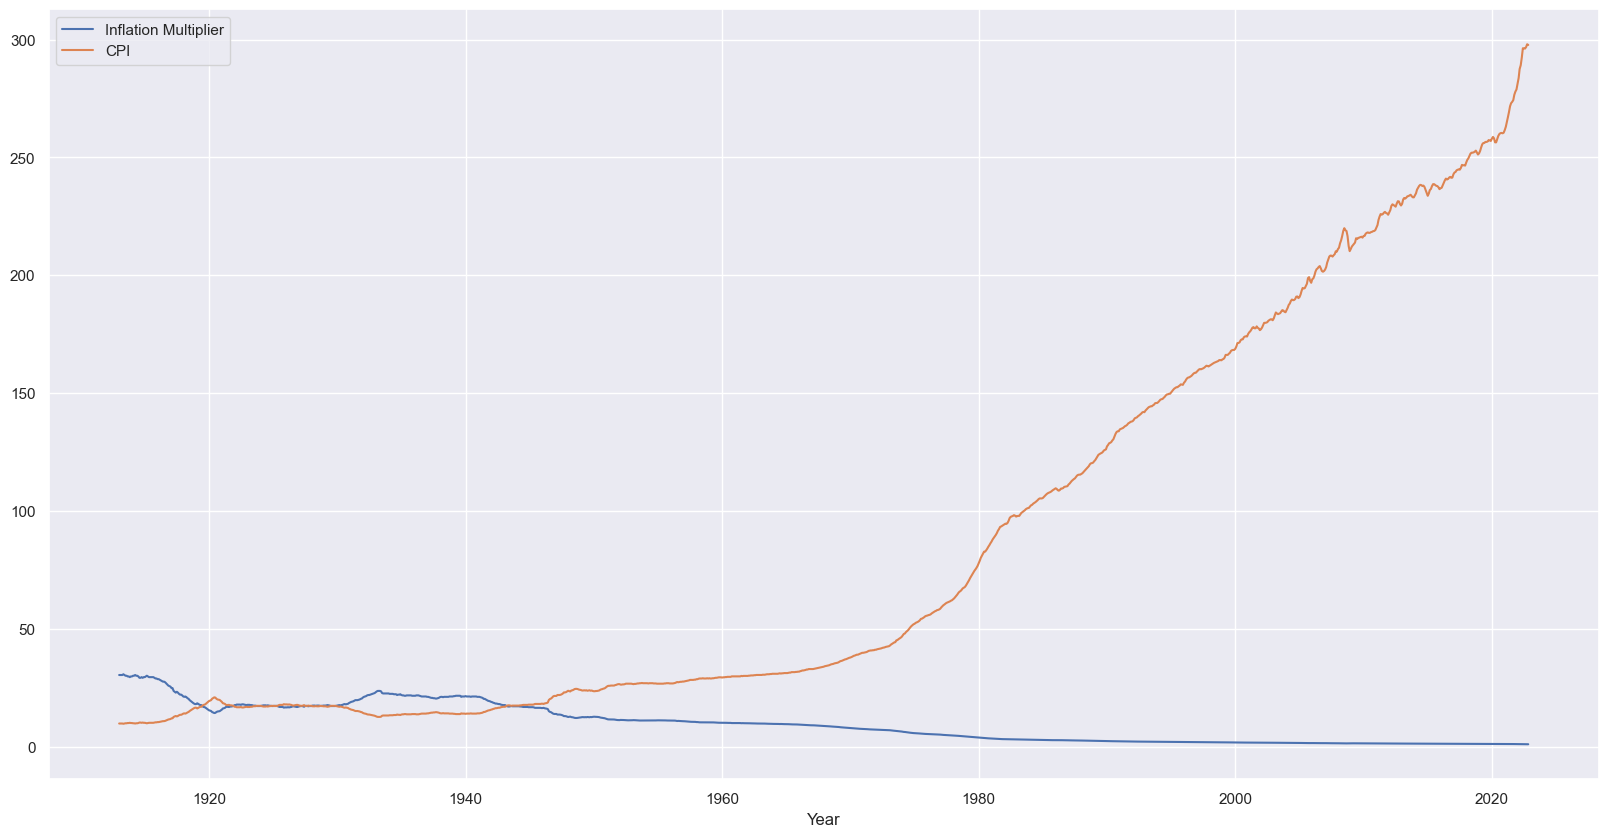

In [175]:
# load inflation data
inflation = pd.read_csv(cpi_path, names=['date', 'cpi'], skiprows=1)
inflation['date'] = pd.to_datetime(inflation['date'])
# calculate inflation multiplier
inflation['multiplier'] = inflation['cpi'].iloc[-1] / inflation['cpi']
plt.plot(inflation['date'], inflation['multiplier'], label='Inflation Multiplier')
plt.plot(inflation['date'], inflation['cpi'], label='CPI')
plt.xlabel('Year')
plt.legend();

In [176]:
# generate plotly figure
p = px.line(inflation, x='date', y='cpi', color_discrete_sequence=px.colors.qualitative.T10, template='ggplot2')
p.update_layout(
    title='<b>Consumer Price Index for All Urban Consumers</b> over time<br><sup>Source: Federal Reserve Economic Data</sup>',
    yaxis_title='CPI',
    xaxis_title='Year',
    width=800,
    height=500,
    )
p.show()
p.write_html('cpi.html')

In [177]:
# calculate mean of inflation multiplier per year
multiplier_year = inflation.groupby(inflation['date'].dt.year).mean()
multiplier_year = multiplier_year
multiplier_year

,cpi,multiplier
date,,
1913,9.883333,30.126541
1914,10.016667,29.726907
1915,10.108333,29.455613
1916,10.883333,27.389927
1917,12.825000,23.269261
...,...,...
2018,251.106833,1.185637
2019,255.657417,1.164546
2020,258.811167,1.150337


In [178]:
# filter nan data from raw characters
raw_characters = raw_characters.dropna()
print(raw_characters.shape)
# process age data, make sure age is greater than 0
raw_characters = raw_characters[raw_characters['Actor age at movie release'] > 0]
print('After filtering age data', raw_characters.shape)

(45264, 13)
After filtering age data (45239, 13)


In [179]:
raw_characters

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
56,2314463,/m/0734w5,2006,Taper Guy,1971-05-26,M,1.870,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
76,612710,/m/02wjqm,1999-10-01,Sandii,1975-09-20,F,1.680,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450565,22330502,/m/05sync6,1931-01-31,Yvonne Valbret,1905-09-18,F,1.702,/m/06mvq,Greta Garbo,25.0,/m/05tg4vb,/m/0h2ppfw,/m/0h14h
450585,24997872,/m/09g6klx,2010-05-07,Raja,1951-09-07,M,1.780,/m/04mvp8,Mammootty,58.0,/m/0gvytkx,/m/0h27wx_,/m/02hkv5
450586,24997872,/m/09g6klx,2010-05-07,Surya,1982-10-16,M,1.810,/m/0dryh9k,Prithviraj Sukumaran,27.0,/m/0gw0rm2,/m/0gz549m,/m/0cqcgj
450587,24997872,/m/09g6klx,2010-05-07,Aswathy,1982-09-11,F,1.680,/m/0dryh9k,Shriya Saran,27.0,/m/0gw423l,/m/0gyf84q,/m/09r_wb


In [180]:
# load extended wikidata
ext_chars = processed_path.joinpath('chars_extended.csv')
ext_chars = pd.read_csv(ext_chars)
print(ext_chars.columns)

Index(['movie_id', 'movie_name', 'movie_genre', 'movie_origin',
       'movie_release', 'box_office_value', 'director_id', 'director_name',
       'director_gender', 'director_country', 'director_birth',
       'director_age_at_release', 'producer_id', 'producer_name',
       'producer_gender', 'producer_country', 'producer_birth',
       'producer_age_at_release', 'cast_id_0', 'cast_0_name', 'cast_0_gender',
       'cast_0_country', 'cast_0_birth', 'cast_0_age_at_release', 'cast_id_1',
       'cast_1_name', 'cast_1_gender', 'cast_1_country', 'cast_1_birth',
       'cast_1_age_at_release', 'cast_id_2', 'cast_2_name', 'cast_2_gender',
       'cast_2_country', 'cast_2_birth', 'cast_2_age_at_release', 'cast_id_3',
       'cast_3_name', 'cast_3_gender', 'cast_3_country', 'cast_3_birth',
       'cast_3_age_at_release', 'cast_id_4', 'cast_4_name', 'cast_4_gender',
       'cast_4_country', 'cast_4_birth', 'cast_4_age_at_release'],
      dtype='object')


Text(0, 0.5, 'Number of Movies')

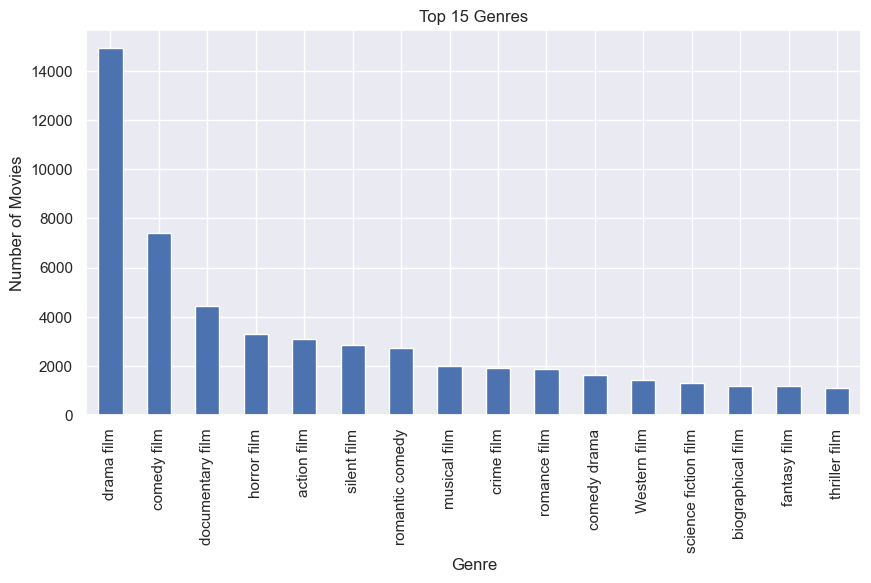

In [183]:
top = 15
sns.histplot(ext_chars['movie_genre'].value_counts()[:top+1], discrete=True)
# ext_chars['movie_genre'].value_counts()[:top+1].plot(kind='bar')
# create a map from genre to number of movies
genre_map = ext_chars['movie_genre'].value_counts()[:top+1].to_dict()
plt.title('Top {} Genres'.format(top))
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

From this plot we can see that most of the movies in the CMU dataset are categorized as 'drama film' and the distribution of category is a long tail distribution.

In [182]:
# plotly barplot
top=21
fig = px.bar(ext_chars['movie_genre'].value_counts()[:top+1], color=ext_chars['movie_genre'].value_counts()[:top+1].index, 
             color_discrete_sequence=px.colors.qualitative.T10,
             template='ggplot2'
             )
fig.update_layout(
    title='<b>Number of movies</b> for the top {} genres<br><sup>CMU Movie Dataset</sup>'.format(top),
    yaxis_title='Number of movies',
    xaxis_title='',
    legend_title='',
    width=800,
    height=500,
    xaxis_tickangle=-45,
)
fig.show()
fig.write_html('top_21_genre_movies.html')

In [134]:
# keys to study in the analysis
study_keys = [
    'movie_id', 
    'cast_0_age_at_release',
    'cast_0_gender',
    'cast_1_age_at_release',
    'cast_1_gender',
    'cast_2_age_at_release',
    'cast_2_gender',
    'cast_3_age_at_release',
    'cast_3_gender',
    'cast_4_age_at_release',
    'cast_4_gender',
    'movie_release',
    'movie_genre',
]

# create a dataframe with these keys

analysis_df = ext_chars[study_keys]

# join with revenue
analysis_df = analysis_df.join(freebase_revenue.set_index('movie_id'), on='movie_id')

# drop nan values
analysis_df = analysis_df.dropna()
# convert release date to year
analysis_df['movie_release_year'] = pd.to_datetime(analysis_df['movie_release']).dt.year

# drop abnormal values
analysis_df = analysis_df[~(analysis_df[['cast_0_age_at_release', 'cast_1_age_at_release', 'cast_2_age_at_release', 'cast_3_age_at_release', 'cast_4_age_at_release']] < 0).any(axis=1)]
analysis_df = analysis_df[~(analysis_df[['cast_0_age_at_release', 'cast_1_age_at_release', 'cast_2_age_at_release', 'cast_3_age_at_release', 'cast_4_age_at_release']] > 100).any(axis=1)]

# filter out top k genres
analysis_df = analysis_df[analysis_df['movie_genre'].isin(analysis_df['movie_genre'].value_counts()[:top].index)]
analysis_df['num_movies_in_this_genre'] = analysis_df['movie_genre'].map(analysis_df['movie_genre'].value_counts())

In [135]:
analysis_df['mean_cast_age'] = analysis_df[['cast_0_age_at_release', 'cast_1_age_at_release', 'cast_2_age_at_release', 'cast_3_age_at_release', 'cast_4_age_at_release']].mean(axis=1)
analysis_df['diff_cast_age'] = analysis_df[['cast_0_age_at_release', 'cast_1_age_at_release', 'cast_2_age_at_release', 'cast_3_age_at_release', 'cast_4_age_at_release']].max(axis=1) \
    - analysis_df[['cast_0_age_at_release', 'cast_1_age_at_release', 'cast_2_age_at_release', 'cast_3_age_at_release', 'cast_4_age_at_release']].min(axis=1)
analysis_df = analysis_df.sort_values(by='movie_release_year')

analysis_df['movie_box_office_revenue'] = analysis_df['Movie box office revenue'].astype(float)
analysis_df.drop(columns=['Movie box office revenue'], inplace=True)

In [136]:
# calibrate revenue with inflation
print('Before calibration', analysis_df.shape)
analysis_df = pd.merge(analysis_df, multiplier_year, left_on='movie_release_year', right_on='date', how='left')
print('After calibration', analysis_df.shape)


Before calibration (6114, 19)
After calibration (6114, 21)


In [137]:
analysis_df.head()

,movie_id,cast_0_age_at_release,cast_0_gender,cast_1_age_at_release,cast_1_gender,cast_2_age_at_release,cast_2_gender,cast_3_age_at_release,cast_3_gender,cast_4_age_at_release,...,movie_release,movie_genre,Freebase Movie ID,movie_release_year,num_movies_in_this_genre,mean_cast_age,diff_cast_age,movie_box_office_revenue,cpi,multiplier
0,Q3941439,30.0,female,35.0,female,28.0,female,36.0,male,51.0,...,1914-01-01,Western film,/m/03gqmqv,1914,145,36.0,23.0,87028.0,10.016667,29.726907
1,Q3874718,28.0,female,47.0,male,44.0,male,34.0,male,40.0,...,1914-01-01,fantasy film,/m/03m5kln,1914,189,38.6,19.0,1000000.0,10.016667,29.726907
2,Q2613688,40.0,male,30.0,female,33.0,male,22.0,male,24.0,...,1914-02-15,Western film,/m/05tz4w,1914,145,29.8,18.0,244700.0,10.016667,29.726907
3,Q220394,22.0,female,21.0,female,24.0,female,37.0,male,43.0,...,1915-01-01,drama film,/m/0151l,1915,1066,29.4,22.0,50000000.0,10.108333,29.455613
4,Q1187189,27.0,female,25.0,male,35.0,male,58.0,male,60.0,...,1920-01-01,romance film,/m/0c5ppr,1920,289,41.0,35.0,4500000.0,20.041667,14.864445


In [138]:
analysis_df['cast_2_gender'].value_counts()

male           3792
female         2313
non-binary        5
trans woman       2
genderfluid       1
trans man         1
Name: cast_2_gender, dtype: int64

In [139]:
female_df = analysis_df.copy()
female_df = female_df.replace('male', 0)
female_df = female_df.replace('genderfluid', 0)
female_df = female_df.replace('non-binary', 0)
female_df = female_df.replace('trans man', 0)
female_df = female_df.replace('trans woman', 0)
female_df = female_df.replace('male organism', 0)

female_df = female_df.replace('female', 1)
analysis_df['mean_female_cast_age'] = female_df['cast_0_age_at_release'] * female_df['cast_0_gender'].astype(float) \
    / (female_df['cast_0_gender'].astype(float) + female_df['cast_1_gender'].astype(float) + \
        female_df['cast_2_gender'].astype(float) + female_df['cast_3_gender'].astype(float) + female_df['cast_4_gender'].astype(float))

In [140]:
def get_gender_mean_age(df, gender='female'):
    female_df = df.copy()
    genders = ['male', 'female', 'genderfluid', 'non-binary', 'trans man', 'trans woman', 'male organism']
    for gen in genders:
        if gen != gender:
            female_df.replace(gen, 0, inplace=True)
    female_df.replace(gender, 1, inplace=True)
    
    ret = female_df['cast_0_age_at_release'] * female_df['cast_0_gender'].astype(float) \
        / (female_df['cast_0_gender'].astype(float) + female_df['cast_1_gender'].astype(float) + \
            female_df['cast_2_gender'].astype(float) + female_df['cast_3_gender'].astype(float) + female_df['cast_4_gender'].astype(float))
    return ret

In [141]:
analysis_df['mean_female_cast_age'] = get_gender_mean_age(analysis_df, 'female')
analysis_df['mean_male_cast_age'] = get_gender_mean_age(analysis_df, 'male')


In [142]:
analysis_df.columns

Index(['movie_id', 'cast_0_age_at_release', 'cast_0_gender',
       'cast_1_age_at_release', 'cast_1_gender', 'cast_2_age_at_release',
       'cast_2_gender', 'cast_3_age_at_release', 'cast_3_gender',
       'cast_4_age_at_release', 'cast_4_gender', 'movie_release',
       'movie_genre', 'Freebase Movie ID', 'movie_release_year',
       'num_movies_in_this_genre', 'mean_cast_age', 'diff_cast_age',
       'movie_box_office_revenue', 'cpi', 'multiplier', 'mean_female_cast_age',
       'mean_male_cast_age'],
      dtype='object')

Text(0, 0.5, 'Revenue')

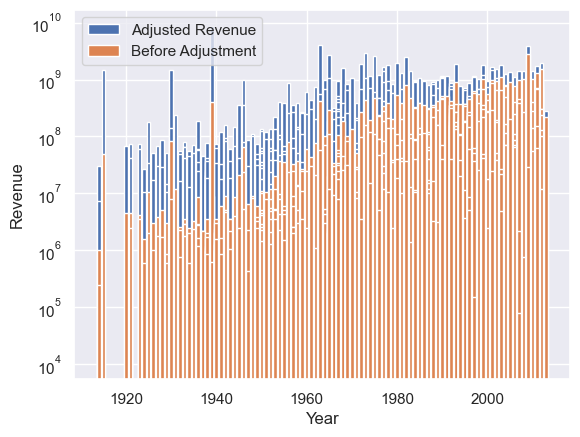

In [143]:
# Compare the revenue before/after ajustment
analysis_df['movie_box_office_revenue_adj'] = analysis_df['movie_box_office_revenue'] * analysis_df['multiplier']
plt.bar(analysis_df['movie_release_year'], analysis_df['movie_box_office_revenue_adj'], label='Adjusted Revenue')
plt.bar(analysis_df['movie_release_year'], analysis_df['movie_box_office_revenue'], label='Before Adjustment')
plt.legend()
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Revenue')

In [144]:
p = px.bar(analysis_df, x='movie_release_year', y='movie_box_office_revenue_adj', color='movie_genre',
           color_discrete_sequence=px.colors.qualitative.T10, 
           log_y=True,
           template='ggplot2',
           range_x=[analysis_df['movie_release_year'].min()-0.5, analysis_df['movie_release_year'].max()-0.5],
           )
p.update_layout(
    xaxis_title='Year',
    yaxis_title='💲Revenue (Adjusted by Inflation)',
    title='<b>💲Adjusted Revenue</b> for the top {} genres <br><sup>CMU Movie Dataset</sup>'.format(top),
    height=500,
    legend_title='<b>Top 10 Genres</b>',
)
p.write_html('adjusted_revenue.html')
p.show()

In [145]:
p = px.histogram(
    analysis_df, x='mean_cast_age', animation_frame='movie_genre', range_x=[0, 100],
    color='movie_genre', range_y=[0, 110], color_discrete_sequence=px.colors.qualitative.T10,
    template='ggplot2'
    )
p.update_layout(
    title='Mean Cast Age Distribution by Genre',
    xaxis_title='Mean Cast Age',
    yaxis_title='Counts',
    legend_title='Genre',
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
)
)
p.show()

The distribution of 

Text(0, 0.5, 'Counts')

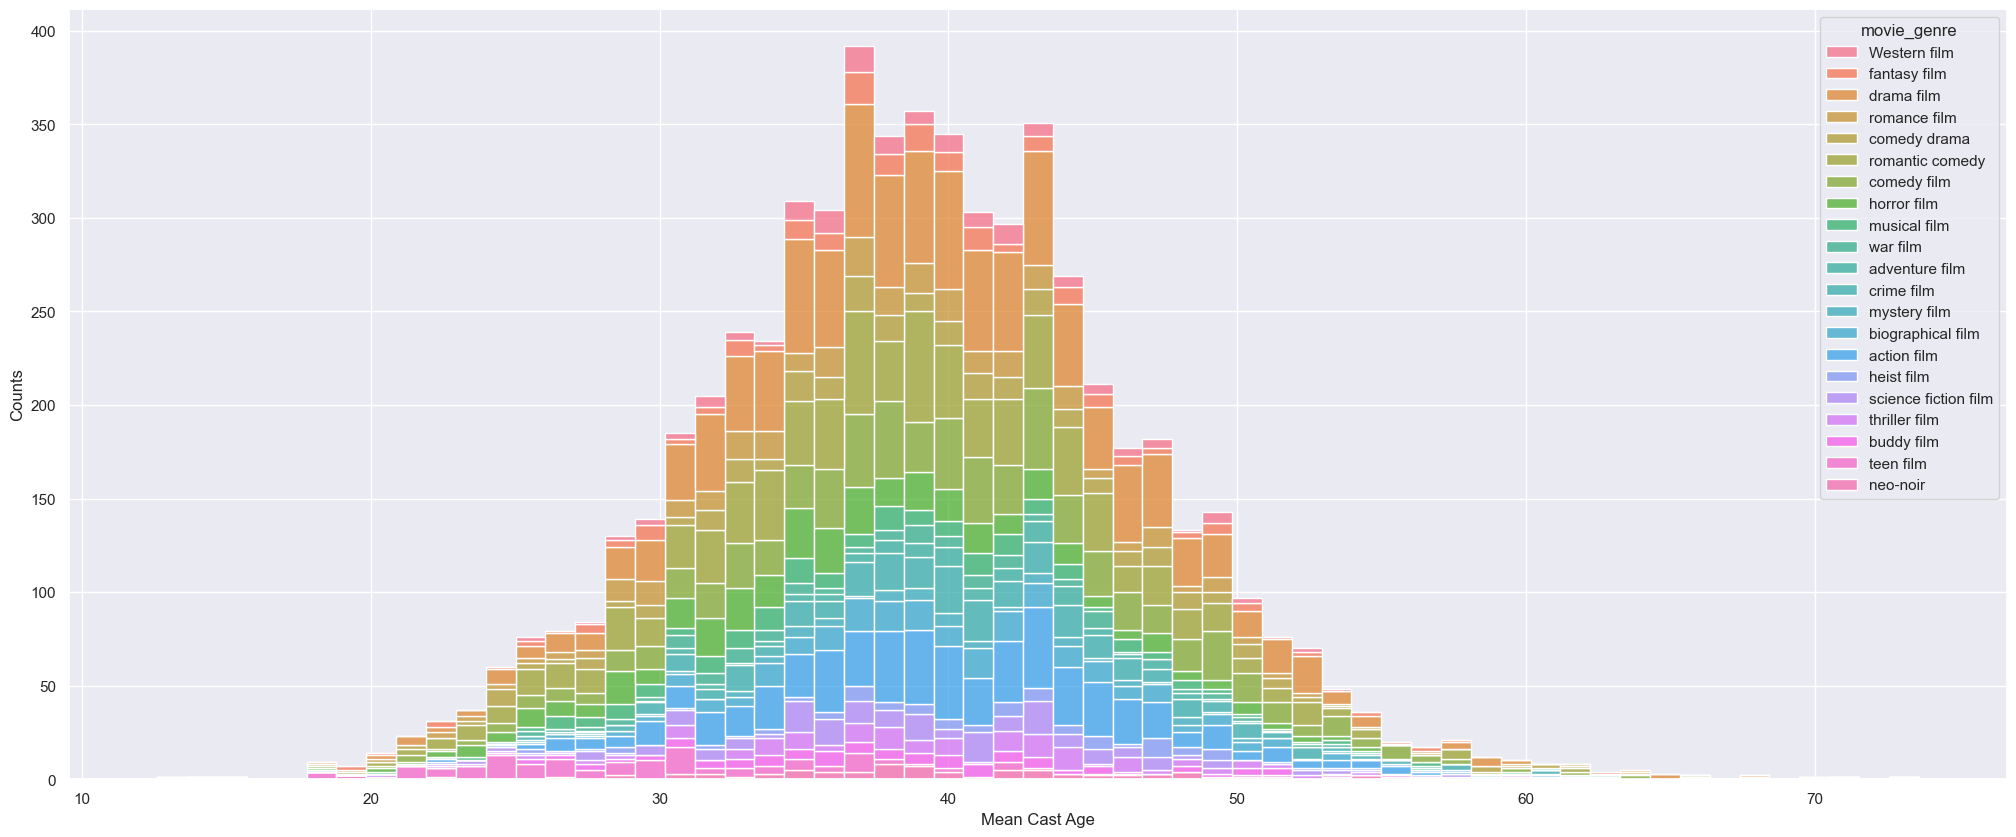

In [146]:
plt.figure(figsize=(25, 10))
sns.histplot(
    data=analysis_df, x='mean_cast_age', hue='movie_genre', multiple='stack',
)
plt.xlabel('Mean Cast Age')
plt.ylabel('Counts')


In [147]:
p = px.histogram(
    analysis_df, x='mean_female_cast_age', animation_frame='movie_genre', range_x=[3, 100],
    color='movie_genre', range_y=[0, 110], color_discrete_sequence=px.colors.qualitative.T10,
    template='ggplot2'
    )
p.update_layout(
    title='Mean Cast Age Distribution by Genre for Female Cast',
    xaxis_title='Mean Cast Age',
    yaxis_title='Counts',
    legend_title='Genre',
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
)
)

p.show()

In [148]:
p = px.histogram(
    analysis_df, x='mean_male_cast_age', animation_frame='movie_genre', range_x=[3, 100],
    color='movie_genre', range_y=[0, 110],
    template='ggplot2',
    color_discrete_sequence=px.colors.qualitative.T10,
    )
p.update_layout(
    title='Mean Cast Age Distribution by Genre for Male Cast',
    xaxis_title='Mean Cast Age',
    yaxis_title='Counts',
    legend_title='Genre',
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
)
)

p.show()

In [149]:
# create a dataframe of numebr of movies per year for all genres
row = []
for genre in analysis_df['movie_genre'].unique():
    row.append(analysis_df.query('movie_genre=="{}"'.format(genre))['movie_release_year'].value_counts().rename(genre))
num_movies_per_year = pd.concat(row, axis=1).fillna(0).astype(int)
num_movies_per_year = num_movies_per_year.sort_index()
num_movies_per_year

,Western film,fantasy film,drama film,romance film,comedy drama,romantic comedy,comedy film,horror film,musical film,war film,...,crime film,mystery film,biographical film,action film,heist film,science fiction film,thriller film,buddy film,teen film,neo-noir
1914,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1915,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1920,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1921,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1923,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0,9,39,11,20,31,21,25,5,1,...,9,2,12,25,1,10,11,5,2,3
2010,0,11,46,13,12,27,22,12,2,4,...,6,0,11,22,3,8,5,3,3,1
2011,0,6,43,7,10,24,27,11,1,5,...,5,0,8,23,1,6,11,2,3,1
2012,0,6,18,1,5,17,12,6,2,1,...,5,1,3,14,0,12,3,1,2,0


In [150]:
# group every 10 years in the genre_revenue dataframe
num_movies_per_year_10 = num_movies_per_year.groupby(np.arange(len(num_movies_per_year))//10).sum().set_index(num_movies_per_year.index[::10])
num_movies_per_year_10

,Western film,fantasy film,drama film,romance film,comedy drama,romantic comedy,comedy film,horror film,musical film,war film,...,crime film,mystery film,biographical film,action film,heist film,science fiction film,thriller film,buddy film,teen film,neo-noir
1914,2,1,10,4,1,2,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1929,2,1,34,9,4,27,6,2,20,2,...,5,1,4,1,0,0,0,0,0,0
1939,6,2,24,12,2,16,4,3,9,7,...,5,3,5,0,0,0,0,0,0,0
1949,97,7,134,24,9,59,38,7,62,31,...,16,6,37,4,5,16,2,4,2,0
1959,8,5,32,5,6,19,19,3,7,5,...,10,3,5,7,5,5,1,0,0,0
1969,12,6,33,5,17,20,14,22,10,4,...,15,6,8,31,11,10,8,4,3,3
1979,5,31,113,36,34,93,98,85,25,12,...,44,10,27,103,5,47,17,14,32,12
1989,9,43,204,60,68,156,171,61,17,14,...,84,19,42,170,25,34,36,48,31,37
1999,4,61,336,102,79,279,205,137,34,29,...,91,25,74,171,42,51,57,33,62,22
2009,0,32,146,32,47,99,82,55,10,11,...,25,3,34,84,5,36,30,11,10,5


In [151]:
number_of_years = len(analysis_df['movie_release_year'].unique())
# create a dataframe with genres as headers and years as index
genre_revenue = pd.DataFrame(index=analysis_df['movie_release_year'].unique(), columns=analysis_df['movie_genre'].unique())
# fill in the dataframe
for year in genre_revenue.index:
    for genre in genre_revenue.columns:
        genre_revenue.loc[year, genre] = analysis_df.query('movie_release_year == @year and movie_genre == @genre')['movie_box_office_revenue_adj'].sum()
genre_revenue.head()


,Western film,fantasy film,drama film,romance film,comedy drama,romantic comedy,comedy film,horror film,musical film,war film,...,crime film,mystery film,biographical film,action film,heist film,science fiction film,thriller film,buddy film,teen film,neo-noir
1914,9861247.24738,29726906.52396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1915,0.0,0.0,1472780633.708431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1920,0.0,0.0,0.0,66890002.86297,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1921,0.0,0.0,15021224.047739,75106120.238696,41725622.354831,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1923,0.0,0.0,72801283.572776,61121930.465366,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
# group every 10 years in the genre_revenue dataframe
genre_revenue_10 = genre_revenue.groupby(np.arange(len(genre_revenue))//10).mean().set_index(genre_revenue.index[::10])
genre_revenue_10

,Western film,fantasy film,drama film,romance film,comedy drama,romantic comedy,comedy film,horror film,musical film,war film,...,crime film,mystery film,biographical film,action film,heist film,science fiction film,thriller film,buddy film,teen film,neo-noir
1914,9.861247e+05,2.972691e+06,1.891756e+08,2.700089e+07,4.172562e+06,4.376846e+06,4.413641e+06,3.395109e+06,8.675575e+06,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1929,3.961481e+06,1.418550e+06,7.972683e+07,2.556964e+07,6.560568e+06,1.029774e+08,1.490065e+07,2.447298e+07,2.186752e+08,1.556278e+07,...,7.622834e+06,9.521593e+05,1.296190e+07,1.945909e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1939,6.149818e+07,1.066223e+07,1.381596e+08,9.025747e+08,7.186606e+06,5.884385e+07,3.492875e+07,1.086333e+07,1.320133e+08,7.225895e+07,...,2.584412e+07,2.151858e+07,2.183841e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1949,2.610819e+08,1.660556e+07,6.535643e+08,7.997720e+07,2.171033e+07,2.187214e+08,1.050533e+08,1.657108e+07,2.595375e+08,1.278382e+08,...,1.049970e+08,1.154685e+07,1.186833e+08,9.778007e+06,7.430444e+06,6.132661e+07,3.096962e+06,1.470799e+07,1.084112e+07,0.000000e+00
1959,9.292088e+07,1.185440e+08,5.007449e+08,1.644561e+08,5.857359e+08,2.796158e+08,1.869782e+08,7.562845e+07,4.741980e+08,1.116948e+08,...,1.373797e+08,3.178439e+07,9.381081e+07,3.901714e+08,6.773368e+07,3.733864e+07,1.889800e+06,0.000000e+00,0.000000e+00,0.000000e+00
1969,9.956677e+07,7.290012e+07,8.251000e+08,1.701552e+08,2.539489e+08,5.317682e+08,3.387594e+08,6.286500e+08,3.975133e+08,7.613268e+07,...,2.056074e+08,8.054029e+07,1.806819e+08,7.446046e+08,2.391872e+08,2.549767e+08,4.417832e+08,1.466364e+08,1.017262e+08,4.164005e+07
1979,2.346287e+07,2.378747e+08,8.308177e+08,4.045565e+08,1.805152e+08,1.000118e+09,8.022736e+08,5.397859e+08,2.276972e+08,1.369095e+08,...,2.534596e+08,3.254579e+07,2.471873e+08,1.617289e+09,2.748327e+07,9.760476e+08,2.633743e+08,1.627136e+08,2.426654e+08,1.269130e+08
1989,6.942333e+07,5.351092e+08,9.010175e+08,7.614684e+08,4.176575e+08,1.386975e+09,1.321783e+09,4.277382e+08,1.384533e+08,2.842237e+08,...,9.775013e+08,7.505873e+07,2.638429e+08,2.847020e+09,3.209959e+08,9.342365e+08,2.761998e+08,4.174154e+08,1.022456e+08,2.934965e+08
1999,1.413201e+07,2.250712e+09,1.463599e+09,7.433282e+08,2.220163e+08,2.966619e+09,1.819314e+09,1.351927e+09,3.033955e+08,4.970884e+08,...,7.179509e+08,3.416826e+08,5.479917e+08,3.496988e+09,6.585941e+08,1.232730e+09,5.974475e+08,3.592931e+08,3.007852e+08,1.203793e+08
2009,0.000000e+00,2.521393e+09,8.556881e+08,7.964823e+08,4.832358e+08,1.838700e+09,1.399271e+09,7.825646e+08,3.240767e+08,2.170227e+08,...,3.814491e+08,1.400263e+08,4.119853e+08,3.586806e+09,3.781067e+08,2.224410e+09,3.802626e+08,2.587016e+08,6.988550e+07,1.363849e+08


In [153]:
# create a dataframe with genres as headers and years as index and diff_cast_age as values
genre_diff_age = pd.DataFrame(index=analysis_df['movie_release_year'].unique(), columns=analysis_df['movie_genre'].unique())
# fill in the dataframe
for year in genre_diff_age.index:
    for genre in genre_diff_age.columns:
        genre_diff_age.loc[year, genre] = analysis_df.query('movie_release_year == @year and movie_genre == @genre')['diff_cast_age'].mean()
genre_diff_age.head()



,Western film,fantasy film,drama film,romance film,comedy drama,romantic comedy,comedy film,horror film,musical film,war film,...,crime film,mystery film,biographical film,action film,heist film,science fiction film,thriller film,buddy film,teen film,neo-noir
1914,20.5,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1915,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1921,NaN,NaN,38.0,33.0,46.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1923,NaN,NaN,33.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
# group every 10 years in the genre_diff_age dataframe
genre_diff_age_10 = genre_diff_age.groupby(np.arange(len(genre_diff_age))//10).mean().set_index(genre_diff_age.index[::10])
genre_diff_age_10

,Western film,fantasy film,drama film,romance film,comedy drama,romantic comedy,comedy film,horror film,musical film,war film,...,crime film,mystery film,biographical film,action film,heist film,science fiction film,thriller film,buddy film,teen film,neo-noir
1914,20.500000,19.000000,27.562500,33.000000,46.000000,35.500000,28.000000,26.000000,38.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929,18.500000,51.000000,30.936905,34.450000,33.000000,28.920370,28.777778,27.000000,26.350000,22.500000,...,23.555556,40.000000,31.500000,47.000000,NaN,NaN,NaN,NaN,NaN,NaN
1939,28.125000,46.500000,33.683333,32.380952,29.500000,34.218750,34.833333,34.333333,31.550000,33.000000,...,25.800000,35.000000,30.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,27.045536,34.733333,24.297620,27.641667,35.233333,31.466591,28.762897,23.400000,28.950119,22.311190,...,26.979167,37.916667,28.322917,32.833333,21.500000,30.222222,37.500000,24.500000,31.500000,NaN
1959,32.366667,34.000000,26.574074,30.000000,28.600000,29.581481,32.350000,37.000000,28.833333,19.800000,...,21.066667,18.000000,20.800000,25.333333,28.916667,32.750000,42.000000,NaN,NaN,NaN
1969,29.023810,41.833333,25.893333,27.125000,22.781250,23.379630,25.295918,33.916667,26.416667,18.500000,...,20.854167,24.083333,24.071429,29.136772,27.062500,33.142857,25.166667,27.500000,11.333333,24.000000
1979,18.375000,32.962500,30.525534,29.645833,32.049048,28.949696,28.905274,31.350786,27.641667,25.687500,...,28.230000,20.976190,31.850000,27.202418,29.250000,28.886111,29.055556,22.690476,23.261111,26.357143
1989,24.566667,32.153333,31.056604,30.125833,32.366471,27.163673,29.580159,30.904048,37.071429,20.736111,...,26.748013,25.783333,28.551667,26.350198,27.101852,31.985000,27.184167,27.271061,27.219167,29.723810
1999,23.833333,36.032500,31.248565,28.432585,30.872974,24.964842,29.165630,27.769074,28.843333,27.066667,...,30.258963,34.500000,28.279393,27.743520,28.524074,31.350353,27.768929,28.200000,23.517381,25.566667
2009,NaN,35.777778,32.522485,34.501748,33.804167,25.557251,27.218975,31.832606,36.525000,26.250000,...,25.844444,20.000000,28.546402,26.072815,29.444444,27.345833,30.554545,24.375000,21.666667,24.666667


In [155]:
# create a dataframe with genres as headers and years as index and mean_cast_age as values
genre_mean_age = pd.DataFrame(index=analysis_df['movie_release_year'].unique(), columns=analysis_df['movie_genre'].unique())
# fill in the dataframe
for year in genre_mean_age.index:
    for genre in genre_mean_age.columns:
        genre_mean_age.loc[year, genre] = analysis_df.query('movie_release_year == @year and movie_genre == @genre')['mean_cast_age'].mean()
genre_mean_age.head()




,Western film,fantasy film,drama film,romance film,comedy drama,romantic comedy,comedy film,horror film,musical film,war film,...,crime film,mystery film,biographical film,action film,heist film,science fiction film,thriller film,buddy film,teen film,neo-noir
1914,32.9,38.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1915,NaN,NaN,29.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920,NaN,NaN,NaN,41.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1921,NaN,NaN,33.8,33.8,26.2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1923,NaN,NaN,37.4,41.6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
genre_mean_age_10 = genre_mean_age.groupby(np.arange(len(genre_mean_age))//10).mean().set_index(genre_mean_age.index[::10])
genre_mean_age_10

,Western film,fantasy film,drama film,romance film,comedy drama,romantic comedy,comedy film,horror film,musical film,war film,...,crime film,mystery film,biographical film,action film,heist film,science fiction film,thriller film,buddy film,teen film,neo-noir
1914,32.900000,38.600000,34.275000,37.900000,26.200000,38.900000,21.000000,36.800000,23.600000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929,37.900000,31.000000,38.044333,39.930000,38.066667,38.665926,36.100000,36.800000,35.537778,37.700000,...,38.222222,34.000000,39.300000,30.000000,NaN,NaN,NaN,NaN,NaN,NaN
1939,40.175000,38.600000,40.546667,38.809524,43.100000,42.675000,43.500000,37.866667,39.960000,40.000000,...,42.000000,39.666667,39.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,38.602202,42.373333,38.960121,39.235000,40.493333,41.453121,40.051885,35.933333,38.775825,38.142476,...,42.091667,44.516667,39.370833,39.100000,35.275000,41.935556,40.800000,36.750000,32.600000,NaN
1959,45.380000,39.175000,38.912963,35.120000,41.420000,38.848889,38.600000,37.350000,34.900000,42.400000,...,38.026667,37.350000,40.320000,41.133333,43.366667,38.900000,33.800000,NaN,NaN,NaN
1969,42.895238,45.333333,38.130571,37.425000,41.512500,37.764815,41.861224,39.735417,35.450000,49.200000,...,41.616667,45.583333,37.871429,42.413228,43.075000,42.514286,41.683333,38.066667,23.733333,37.266667
1979,36.650000,38.770833,39.552400,38.439167,38.734286,39.526074,42.075945,36.722335,39.038333,39.075000,...,42.157667,39.980952,39.867778,41.002654,43.500000,39.549833,43.537037,36.945238,28.528148,42.028571
1989,40.686667,38.511333,39.604350,38.602652,38.240703,39.123063,40.119810,36.725167,42.607143,34.530556,...,39.756220,38.688333,39.283333,39.905124,40.714815,39.020333,40.625833,38.091091,32.610333,43.538095
1999,34.400000,37.188500,39.789936,36.590391,37.886692,36.711751,40.220040,35.417637,36.781667,37.557037,...,41.168087,39.168519,39.817200,39.158216,41.995397,38.859083,39.929357,39.140000,28.990516,37.120000
2009,NaN,38.649747,41.076695,38.490210,40.551667,39.496564,39.590320,40.977770,42.320000,41.152500,...,42.922778,33.550000,41.371402,41.188630,41.488889,37.896667,38.766061,39.456667,31.008333,43.933333


In [157]:
# create a dataframe with years as index and genres revenue diff_cast_age as values
rows = []
for year in genre_revenue_10.index:
    for genre in genre_revenue_10.columns:
        # year , genre, revenue, diff_cast_age, num_movies_in_this_genre
        rows.append([year, genre, genre_revenue_10.loc[year, genre], genre_diff_age_10.loc[year, genre],\
            genre_mean_age_10.loc[year, genre], num_movies_per_year_10.loc[year, genre]])
        
df_plot = pd.DataFrame(rows, columns=['year', 'genre', 'revenue_ajusted', 'diff_cast_age', 'mean_cast_age', 'num_of_movies'])
df_plot['revenue_ajusted'] = df_plot['revenue_ajusted'].astype(float)
df_plot.head()

,year,genre,revenue_ajusted,diff_cast_age,mean_cast_age,num_of_movies
0,1914,Western film,9.861247e+05,20.5000,32.900,2
1,1914,fantasy film,2.972691e+06,19.0000,38.600,1
2,1914,drama film,1.891756e+08,27.5625,34.275,10
3,1914,romance film,2.700089e+07,33.0000,37.900,4
4,1914,comedy drama,4.172562e+06,46.0000,26.200,1


In [158]:
df_plot['diff_cast_age'].max()

51.0

In [159]:
fig = px.scatter(
    df_plot, x='diff_cast_age', y='revenue_ajusted', 
    color='genre', log_y=True, range_y=[1e6, df_plot['revenue_ajusted'].max()*100], animation_frame='year',
    range_x = [df_plot['diff_cast_age'].min()-11, df_plot['diff_cast_age'].max()+1], size='num_of_movies', size_max=90,
    color_discrete_sequence=px.colors.qualitative.T10,
    template='ggplot2'
)
fig.update_layout(
    title='<b>Revenue vs. Cast Age Difference</b> by Genre</b><br><sup>Size of the bubble is the number of movies  in that period of time</sup>',
    xaxis_title='Cast Age Difference',
    yaxis_title='Revenue (Adjusted by Inflation)',
    legend_title='Genre',
)
fig.write_html('revenue_vs_cast_age_diff.html')
fig.show()


In [160]:
fig = px.scatter(
    df_plot, x='mean_cast_age', y='revenue_ajusted', 
    color='genre', log_y=True, range_y=[1e6, df_plot['revenue_ajusted'].max()*100], animation_frame='year',
    range_x = [df_plot['mean_cast_age'].min()-11, df_plot['mean_cast_age'].max()+1], size='num_of_movies', size_max=90,
    color_discrete_sequence=px.colors.qualitative.T10,
    template='ggplot2'
)
fig.update_layout(
    title='<b>Revenue vs. Mean Cast Age</b> by Genre<br><sup>Size of the bubble is the number of movies in that genre in that period of time</sup>',
    xaxis_title='Mean Cast Age',
    yaxis_title='Revenue (Adjusted by Inflation)',
    legend_title='Genre',
)
fig.write_html('revenue_vs_mean_cast_age.html')
fig.show()


In [161]:

genre_mean_age_10

,Western film,fantasy film,drama film,romance film,comedy drama,romantic comedy,comedy film,horror film,musical film,war film,...,crime film,mystery film,biographical film,action film,heist film,science fiction film,thriller film,buddy film,teen film,neo-noir
1914,32.900000,38.600000,34.275000,37.900000,26.200000,38.900000,21.000000,36.800000,23.600000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929,37.900000,31.000000,38.044333,39.930000,38.066667,38.665926,36.100000,36.800000,35.537778,37.700000,...,38.222222,34.000000,39.300000,30.000000,NaN,NaN,NaN,NaN,NaN,NaN
1939,40.175000,38.600000,40.546667,38.809524,43.100000,42.675000,43.500000,37.866667,39.960000,40.000000,...,42.000000,39.666667,39.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,38.602202,42.373333,38.960121,39.235000,40.493333,41.453121,40.051885,35.933333,38.775825,38.142476,...,42.091667,44.516667,39.370833,39.100000,35.275000,41.935556,40.800000,36.750000,32.600000,NaN
1959,45.380000,39.175000,38.912963,35.120000,41.420000,38.848889,38.600000,37.350000,34.900000,42.400000,...,38.026667,37.350000,40.320000,41.133333,43.366667,38.900000,33.800000,NaN,NaN,NaN
1969,42.895238,45.333333,38.130571,37.425000,41.512500,37.764815,41.861224,39.735417,35.450000,49.200000,...,41.616667,45.583333,37.871429,42.413228,43.075000,42.514286,41.683333,38.066667,23.733333,37.266667
1979,36.650000,38.770833,39.552400,38.439167,38.734286,39.526074,42.075945,36.722335,39.038333,39.075000,...,42.157667,39.980952,39.867778,41.002654,43.500000,39.549833,43.537037,36.945238,28.528148,42.028571
1989,40.686667,38.511333,39.604350,38.602652,38.240703,39.123063,40.119810,36.725167,42.607143,34.530556,...,39.756220,38.688333,39.283333,39.905124,40.714815,39.020333,40.625833,38.091091,32.610333,43.538095
1999,34.400000,37.188500,39.789936,36.590391,37.886692,36.711751,40.220040,35.417637,36.781667,37.557037,...,41.168087,39.168519,39.817200,39.158216,41.995397,38.859083,39.929357,39.140000,28.990516,37.120000
2009,NaN,38.649747,41.076695,38.490210,40.551667,39.496564,39.590320,40.977770,42.320000,41.152500,...,42.922778,33.550000,41.371402,41.188630,41.488889,37.896667,38.766061,39.456667,31.008333,43.933333


In [162]:
df_plot


,year,genre,revenue_ajusted,diff_cast_age,mean_cast_age,num_of_movies
0,1914,Western film,9.861247e+05,20.500000,32.900000,2
1,1914,fantasy film,2.972691e+06,19.000000,38.600000,1
2,1914,drama film,1.891756e+08,27.562500,34.275000,10
3,1914,romance film,2.700089e+07,33.000000,37.900000,4
4,1914,comedy drama,4.172562e+06,46.000000,26.200000,1
...,...,...,...,...,...,...
205,2009,science fiction film,2.224410e+09,27.345833,37.896667,36
206,2009,thriller film,3.802626e+08,30.554545,38.766061,30
207,2009,buddy film,2.587016e+08,24.375000,39.456667,11
208,2009,teen film,6.988550e+07,21.666667,31.008333,10


<AxesSubplot:>

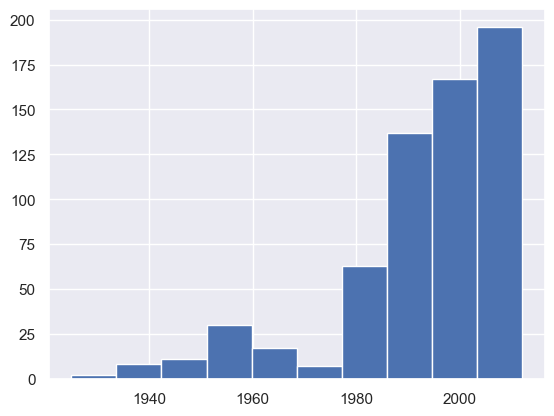

In [163]:
analysis_df[analysis_df['movie_genre']=='comedy film']['movie_release_year'].hist()

In [164]:
analysis_df.columns

Index(['movie_id', 'cast_0_age_at_release', 'cast_0_gender',
       'cast_1_age_at_release', 'cast_1_gender', 'cast_2_age_at_release',
       'cast_2_gender', 'cast_3_age_at_release', 'cast_3_gender',
       'cast_4_age_at_release', 'cast_4_gender', 'movie_release',
       'movie_genre', 'Freebase Movie ID', 'movie_release_year',
       'num_movies_in_this_genre', 'mean_cast_age', 'diff_cast_age',
       'movie_box_office_revenue', 'cpi', 'multiplier', 'mean_female_cast_age',
       'mean_male_cast_age', 'movie_box_office_revenue_adj'],
      dtype='object')

In [165]:
model = smf.ols(formula='movie_box_office_revenue_adj ~ diff_cast_age * mean_cast_age * movie_release_year * C(movie_genre)\
                * mean_female_cast_age',
                data=analysis_df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     movie_box_office_revenue_adj   R-squared:                       0.110
Model:                                      OLS   Adj. R-squared:                  0.054
Method:                           Least Squares   F-statistic:                     1.962
Date:                          Fri, 23 Dec 2022   Prob (F-statistic):           3.56e-21
Time:                                  17:45:34   Log-Likelihood:            -1.1660e+05
No. Observations:                          5646   AIC:                         2.339e+05
Df Residuals:                              5311   BIC:                         2.361e+05
Df Model:                                   334                                         
Covariance Type:                      nonrobust                                         
==============================================================================================================================================================================
                                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                    1.66e+09   4.38e+10      0.038      0.970   -8.43e+10    8.76e+10
C(movie_genre)[T.action film]                                                                              -6.304e+10   5.22e+10     -1.207      0.227   -1.65e+11    3.93e+10
C(movie_genre)[T.adventure film]                                                                           -1.766e+10   7.59e+10     -0.233      0.816   -1.66e+11    1.31e+11
C(movie_genre)[T.biographical film]                                                                          3.96e+08   5.26e+10      0.008      0.994   -1.03e+11    1.03e+11
C(movie_genre)[T.buddy film]                                                                                3.441e+10   9.15e+10      0.376      0.707   -1.45e+11    2.14e+11
C(movie_genre)[T.comedy drama]                                                                              3.167e+10   5.54e+10      0.572      0.567   -7.69e+10     1.4e+11
C(movie_genre)[T.comedy film]                                                                               6.041e+09    4.8e+10      0.126      0.900   -8.81e+10       1e+11
C(movie_genre)[T.crime film]                                                                               -2.474e+10   5.61e+10     -0.441      0.659   -1.35e+11    8.53e+10
C(movie_genre)[T.drama film]                                                                                1.231e+10   4.56e+10      0.270      0.787   -7.71e+10    1.02e+11
C(movie_genre)[T.fantasy film]                                                                              9.321e+09   6.68e+10      0.139      0.889   -1.22e+11     1.4e+11
C(movie_genre)[T.heist film]                                                                               -4.191e+10    1.3e+11     -0.323      0.747   -2.96e+11    2.13e+11
C(movie_genre)[T.horror film]                                                                               3.769e+09   5.28e+10      0.071      0.943   -9.96e+10    1.07e+11
C(movie_genre)[T.musical film]                                                                             -4.076e+09   4.99e+10     -0.082      0.935   -1.02e+11    9.38e+10
C(movie_genre)[T.mystery film]                                                                              1.052e+11   8.16e+10      1.289      0.197   -5.48e+10    2.65e+1